<a href="https://colab.research.google.com/github/FrancescoZanni/MLPNS_FZanni/blob/main/clustering/Clustering_Esercizio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pylab as pl
import sklearn as skl
from sklearn import preprocessing
import scipy as sp
from scipy import spatial
import numpy as np
from sklearn import cluster


cmag = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/clustering/colormag_NGC2808.csv", header=None)
cmag.describe()

,0,1
count,601.000000,601.000000
mean,0.657683,18.751932
std,0.410194,1.320065
min,-0.286449,15.017758
25%,0.485623,17.930904
50%,0.753550,18.925512
75%,0.911292,19.911214
max,1.540265,21.016941


<Figure size 640x480 with 0 Axes>

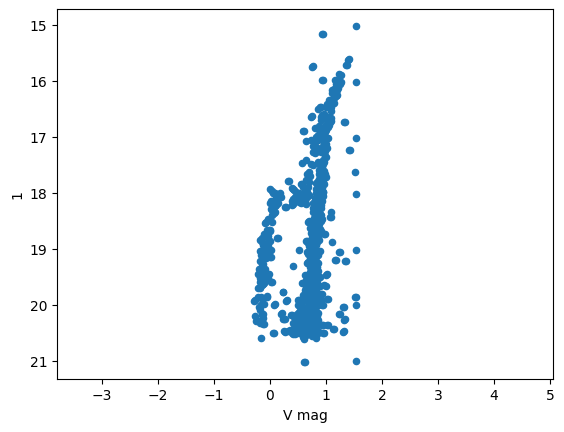

In [ ]:
pl.figure()

ax = cmag.plot(x=0,y=1,kind="scatter")
ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis(); 

Si presta al clustering perchè vedo a occhio che ci sono dei gruppi, ma vedo qualcosa che mi preoccupa: scale diverse, un numero è nelle decine e un altro è nelle unità, ma soprattutto che il range dell'asse x è 1.25 mentre sull'asse y è 6

###devo fare scaling
preprocessing su tutti gli assi, perchè non ho una sequenzialità


In [ ]:
cmag_scaled = preprocessing.scale(cmag,axis=0) %ritorna un array e non un dataframe

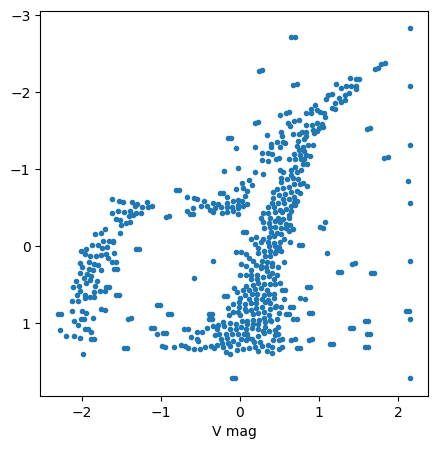

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)

ax.plot(cmag_scaled[:,0],cmag_scaled[:,1],'.')
ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();

##Clustering


In [ ]:
#potrei dire le posizioni iniziali o lo schema da usare per definire i punti iniziali
#viene fatto andare più volte, per il fatto che non e deterministico 
#darò un numero massimo di iterazioni in caso non si raggiunga la convergenza 
#la tolleranza è il criterio di convergenza
#devo dare il random state per la riproducibiità
#faccio finta di non saprere quanti cluster voglio, iniziamo con 3

model = cluster.KMeans(n_clusters=3, random_state=420)

#produce il modello, non ci posso fare niente, devo vedere come utilizzarlo
#il modello ha certe proprietà ma non gli ho dato i dati quindi non ha ancora fatto niente



#come risolvo il non sapere quanti cluster ho? metodo basato sul concetto di inerzia "intra cluster variance" quanto è compatto un gruppo 
#metodo utilizzato ma non ha fondamento matematici, quindi no necessariamente da usare

#mi baso su occam, più cluster (parametri) aggiungo più l'inerzia è bassa, ma non cerco il minimo, cerco quando smette di scendere rapidamente 
#cioè cerco un break nella distribuzione 
#elbow o silouhette method


In [ ]:
model.fit(cmag_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=420)

In [ ]:
model.labels_.shape  #a quale cluster appartiene ogni putno 

(601,)

In [ ]:
model.cluster_centers_   

#il centro di un qualunque cluster è un oggetto nello spazio delle variabili, quindi ha la stessa dimensionalità, ha tante coordinate quante sono le feature del deature space
#sarà più complicato quando pensiamo a clusters in time series, per curve di popolazione, di densità ecc, in quel caso il cluster stesso sarà una time series

array([[ 0.2930383 ,  0.77187379],
       [ 0.62251398, -1.09094667],
       [-1.61167123,  0.31291912]])

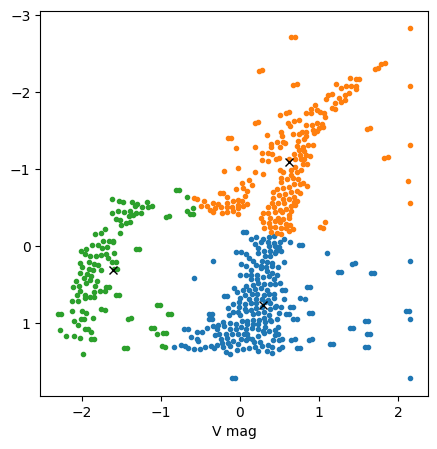

In [ ]:
#rfaccio il plot di prima ma lo coloro sulla base delle labels
ax = pl.figure(figsize=(5,5)).add_subplot(111)

for i in range(3): 
  ax.plot(cmag_scaled[model.labels_==i,0],cmag_scaled[model.labels_==i,1],'.')
  ax.plot(model.cluster_centers_[i,0],model.cluster_centers_[i,1], 'kx')
ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

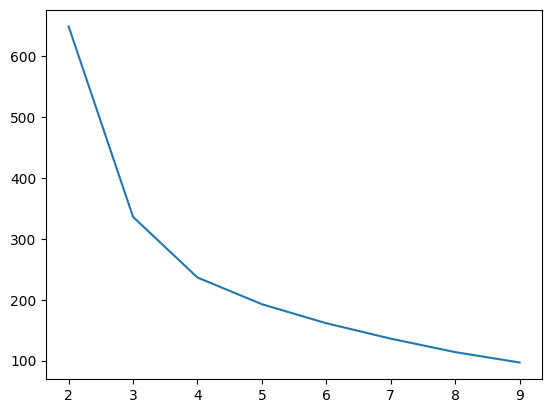

In [ ]:
inertias=[]
for nc in range(2,10): 
  model = cluster.KMeans(n_clusters=nc, random_state=420).fit(cmag_scaled)
  inertias.append(model.inertia_)

pl.plot(range(2,10), inertias)

Questa volta per esempio non è scontato dove sia l'elbow






##conclusione KMEANS
Problema pricipale, non rispetta una delle richieste base: identificare cluster di forma arbitraria

potrei aggiungere una distanza intracluster, cioè mininmizzo la distanza di ogni punto con tutti gli altri punti del cluster, problema di O dell'algoritmo 

possibile soluzione aggiungere una densità,  cioè se trovo un vuoto non va bene 



##Density Based DBSCAN

Uno dei papers più citati in machine learning
(noise in questo caso sta per outliars, non incertezze sui dati!)
Slide con hyperparametri e spiegazione 
SCLALA MOLTO PEGGIO! $O(dN^2)$ con la dimensione e N^2 perchè calcolo tutte le pair distances

OSS: è deterministico!

In [ ]:
#DBSCAN
#devo definire il concetto di densità il default è 0.5 cioè mezza standard dev
# e il minimo di sample nel cluster 5
modeldbs = cluster.DBSCAN(eps = 0.001).fit(cmag_scaled)


In [ ]:
modeldbs.labels_
#tanti 0 e alcuni -1, che identificano gli oulier

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

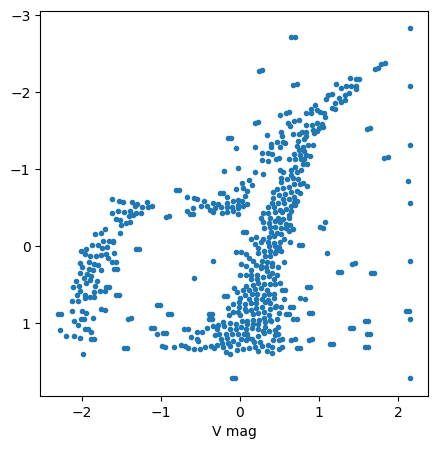

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)

for i in np.unique(modeldbs.labels_): 
  ax.plot(cmag_scaled[modeldbs.labels_==i,0],cmag_scaled[modeldbs.labels_==i,1],'.')


ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();

In [ ]:
#mi accanisco a trovare della struttura 
#si chiama hyperparameter GRID SEARCH
#dovrei farlo anche con min sample
for e in np.arange(0.001,1,0.001):
  modeldbs = cluster.DBSCAN(eps = e).fit(cmag_scaled)
  if modeldbs.labels_.max()>0:
    print(e,modeldbs.labels_.max())


0.067 1
0.068 4
0.069 5
0.07 5
0.07100000000000001 7
0.07200000000000001 8
0.07300000000000001 10
0.074 13
0.075 14
0.076 16
0.077 21
0.078 22
0.079 21
0.08 18
0.081 15
0.082 13
0.083 14
0.084 14
0.085 15
0.08600000000000001 14
0.08700000000000001 13
0.08800000000000001 12
0.089 12
0.09 12
0.091 13
0.092 14
0.093 15
0.094 16
0.095 15
0.096 16
0.097 17
0.098 16
0.099 14
0.1 12
0.101 12
0.10200000000000001 11
0.10300000000000001 11
0.10400000000000001 11
0.10500000000000001 12
0.106 12
0.107 11
0.108 11
0.109 10
0.11 10
0.111 11
0.112 10
0.113 10
0.114 9
0.115 9
0.116 9
0.117 9
0.11800000000000001 10
0.11900000000000001 9
0.12000000000000001 9
0.121 9
0.122 9
0.123 9
0.124 9
0.125 8
0.126 8
0.127 9
0.128 9
0.129 9
0.13 9
0.131 9
0.132 7
0.133 7
0.134 7
0.135 7
0.136 6
0.137 5
0.138 5
0.139 5
0.14 5
0.14100000000000001 4
0.14200000000000002 4
0.14300000000000002 4
0.14400000000000002 4
0.14500000000000002 4
0.146 4
0.147 4
0.148 4
0.149 4
0.15 4
0.151 4
0.152 4
0.153 4
0.154 4
0.155 3
0.1

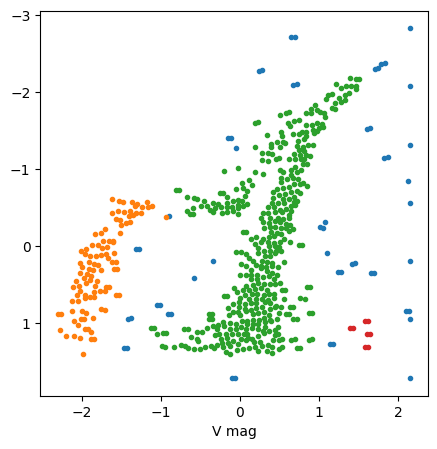

In [ ]:
#scelgo 0.23, un po a caso ma volgio che ci siano 3 clusters
modeldbs = cluster.DBSCAN(eps = 0.23).fit(cmag_scaled)
ax = pl.figure(figsize=(5,5)).add_subplot(111)

for i in np.unique(modeldbs.labels_): 
  ax.plot(cmag_scaled[modeldbs.labels_==i,0],cmag_scaled[modeldbs.labels_==i,1],'.')


ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();


#blu sono sempre gli outliers

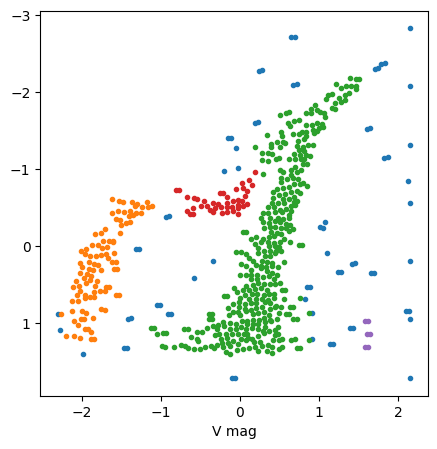

In [ ]:
#scelgo a caso un numero che mi faccia avere 4 clusters

modeldbs = cluster.DBSCAN(eps = 0.18).fit(cmag_scaled)
ax = pl.figure(figsize=(5,5)).add_subplot(111)

for i in np.unique(modeldbs.labels_): 
  ax.plot(cmag_scaled[modeldbs.labels_==i,0],cmag_scaled[modeldbs.labels_==i,1],'.')


ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();


#blu sono sempre gli outliers

In [ ]:
#visto che voreri 3 cluster fatti bene devo cercare la sol ottimale facendo grid scan anche dell'altro parametro
#metto 10 come minimo di distanza 


for e in np.arange(0.001,1,0.001):
  modeldbs = cluster.DBSCAN(eps = e, min_samples = 10).fit(cmag_scaled)
  if modeldbs.labels_.max()>0:
    print(e,modeldbs.labels_.max())


0.109 1
0.11 1
0.111 1
0.112 2
0.113 3
0.114 3
0.115 3
0.116 6
0.117 8
0.11800000000000001 10
0.11900000000000001 11
0.12000000000000001 12
0.121 12
0.122 12
0.123 13
0.124 13
0.125 9
0.126 6
0.127 6
0.128 7
0.129 7
0.13 6
0.131 6
0.132 5
0.133 5
0.134 5
0.135 5
0.136 5
0.137 5
0.138 4
0.139 3
0.14 3
0.14100000000000001 3
0.14200000000000002 4
0.14300000000000002 4
0.14400000000000002 4
0.14500000000000002 4
0.146 5
0.147 6
0.148 6
0.149 6
0.15 6
0.151 6
0.152 5
0.153 6
0.154 6
0.155 6
0.156 6
0.157 6
0.158 6
0.159 7
0.16 7
0.161 7
0.162 7
0.163 7
0.164 7
0.165 7
0.166 7
0.167 7
0.168 7
0.169 6
0.17 6
0.171 6
0.17200000000000001 6
0.17300000000000001 6
0.17400000000000002 5
0.17500000000000002 5
0.17600000000000002 5
0.177 5
0.178 5
0.179 4
0.18 4
0.181 4
0.182 4
0.183 4
0.184 4
0.185 3
0.186 3
0.187 3
0.188 3
0.189 3
0.19 3
0.191 3
0.192 3
0.193 3
0.194 3
0.195 3
0.196 3
0.197 3
0.198 2
0.199 2
0.2 2
0.201 2
0.202 2
0.203 2
0.20400000000000001 2
0.20500000000000002 2
0.206000000000000

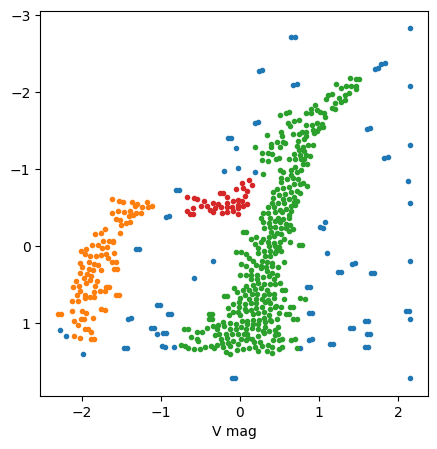

In [ ]:
modeldbs = cluster.DBSCAN(eps = 0.2, min_samples=10).fit(cmag_scaled)
ax = pl.figure(figsize=(5,5)).add_subplot(111)

for i in np.unique(modeldbs.labels_): 
  ax.plot(cmag_scaled[modeldbs.labels_==i,0],cmag_scaled[modeldbs.labels_==i,1],'.')


ax.set_xlabel("B-V (color)")
ax.set_xlabel("V mag")
pl.gca().invert_yaxis();


Ho un risultato ottimale per quello che riguarda ciò che riesco a fare con l'algoritmo però non è ciò che imporrebbe la fisica